In [1]:
import pandas as pd
import numpy as np
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import classification_report,f1_score,roc_auc_score
import kds
from sklearn.preprocessing import LabelEncoder
import shap
import xgboost as xgb
import xgbfir
from catboost import CatBoostClassifier
import scorecardpy as sc
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import RandomizedSearchCV
import pickle

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
train = pd.read_csv('X_train.csv',sep="|")
test = pd.read_csv('X_test.csv',sep="|")
train.head()

,id,revolvingutilizationofunsecuredlines,age,numberoftime3059dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime6089dayspastduenotworse,numberofdependents,target,AGE_BIN,REVOLVING_UTILIZATION_BIN,NO_TIMES_30PASTDUE_BIN,DebtRatio_BIN,MonthlyIncome_BIN,NumberOfTimes90DaysLate_BIN,NumberOfTime6089DaysPastDueNotWorse_BIN
0,99667,0.395285,52,0,2791.000000,NaN,13,0,1,0,3.0,0,49-55,0.22-0.68,0,More than 0.35,MISSING,0,0
1,40877,0.047125,67,0,0.269608,10492.0,5,0,2,0,0.0,0,More than 67,0.04-0.22,0,0-0.35,More than 5330,0,0
2,30554,0.980013,49,0,0.077280,5175.0,3,2,0,1,1.0,1,49-55,More than 0.68,0,0-0.35,0-5330,More than 0,More than 0
3,140513,0.691138,54,0,0.687868,13583.0,9,0,1,0,0.0,0,49-55,More than 0.68,0,More than 0.35,More than 5330,0,0
4,61726,0.073926,23,0,0.000703,2845.0,2,0,0,0,0.0,0,0-36,0.04-0.22,0,0-0.35,0-5330,0,0


In [3]:
target = train['target']
train.drop(columns='target',inplace=True)
X_train,X_test,y_train,y_test = train_test_split(train,target,test_size=0.3,random_state=88,stratify=target,shuffle=True)
X_train['target'] = y_train
X_test['target'] = y_test
print(X_train.shape)
print(X_test.shape)

(73500, 19)
(31500, 19)


In [4]:
features=['AGE_BIN','REVOLVING_UTILIZATION_BIN','NO_TIMES_30PASTDUE_BIN','DebtRatio_BIN','MonthlyIncome_BIN'
          ,'NumberOfTimes90DaysLate_BIN','NumberOfTime6089DaysPastDueNotWorse_BIN']
X_train = X_train.sample(frac=1).reset_index(drop=True)
y_train_bin = X_train['target']
y_test_bin = X_test['target']
X_train_bin = X_train[features]
X_test_bin = X_test[features]
print(X_train_bin.shape)
print(X_test_bin.shape)

(73500, 7)
(31500, 7)


In [5]:
params={
    'objective':'binary:logistic'
    ,'eval_metric':'auc'
    ,'learning_rate':0.05
    ,'max_depth':3
    ,'scale_pos_weight':14
    ,'subsample':0.7
    ,'colsample_bytree':0.7
    ,'min_child_weight':5
}

In [6]:
n_fold = 5
auc_metric={}
predoff = np.zeros(X_train_bin.shape[0])
skf = StratifiedKFold(n_splits=n_fold,random_state=88,shuffle=True)
for f,(train_index,test_index) in enumerate(skf.split(X=X_train_bin,y=y_train_bin)):
    print("Fold",f)
    fold_train = X_train_bin.iloc[train_index]
    fold_valid = X_train_bin.iloc[test_index]
    fold_train_target = y_train_bin[train_index]
    fold_valid_target = y_train_bin[test_index]
    for c in features:
        lbl = LabelEncoder()
        fold_train[c] = lbl.fit_transform(fold_train[c])
        fold_valid[c] = lbl.fit_transform(fold_valid[c])
    
    clf = xgb.XGBClassifier(**params,n_estimators=10000,random_state=88)
    clf.fit(fold_train,fold_train_target,eval_set=[(fold_train,fold_train_target),(fold_valid,fold_valid_target)]
           ,early_stopping_rounds=200,verbose=100
           )
    predval = clf.predict_proba(fold_valid)[:,1]
    fold_valid['prediction'] = predval
    predoff[test_index] = predval
    auc_metric[f+1] = roc_auc_score(fold_valid_target,predval)
    
    print("ROC Score",roc_auc_score(fold_valid_target,predval))

Fold 0
[0]	validation_0-auc:0.80954	validation_1-auc:0.80422



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[100]	validation_0-auc:0.85656	validation_1-auc:0.85026
[200]	validation_0-auc:0.85864	validation_1-auc:0.85136
[300]	validation_0-auc:0.85939	validation_1-auc:0.85145
[400]	validation_0-auc:0.85991	validation_1-auc:0.85139
[460]	validation_0-auc:0.86018	validation_1-auc:0.85123
ROC Score 0.8515859460669661
Fold 1



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-auc:0.80712	validation_1-auc:0.81188
[100]	validation_0-auc:0.85561	validation_1-auc:0.85443
[200]	validation_0-auc:0.85726	validation_1-auc:0.85541
[300]	validation_0-auc:0.85822	validation_1-auc:0.85610
[400]	validation_0-auc:0.85876	validation_1-auc:0.85623
[500]	validation_0-auc:0.85912	validation_1-auc:0.85633
[600]	validation_0-auc:0.85936	validation_1-auc:0.85592
[700]	validation_0-auc:0.85955	validation_1-auc:0.85587
[736]	validation_0-auc:0.85968	validation_1-auc:0.85581
ROC Score 0.8564404951764804
Fold 2



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-auc:0.80626	validation_1-auc:0.81531
[100]	validation_0-auc:0.85437	validation_1-auc:0.85952
[200]	validation_0-auc:0.85650	validation_1-auc:0.85972
[300]	validation_0-auc:0.85745	validation_1-auc:0.85939
[371]	validation_0-auc:0.85782	validation_1-auc:0.85903
ROC Score 0.8597535222052578
Fold 3



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-auc:0.80891	validation_1-auc:0.80703
[100]	validation_0-auc:0.85519	validation_1-auc:0.85571
[200]	validation_0-auc:0.85735	validation_1-auc:0.85626
[300]	validation_0-auc:0.85827	validation_1-auc:0.85640
[400]	validation_0-auc:0.85876	validation_1-auc:0.85603
[453]	validation_0-auc:0.85895	validation_1-auc:0.85615
ROC Score 0.8564769262933156
Fold 4



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-auc:0.81070	validation_1-auc:0.79975
[100]	validation_0-auc:0.85644	validation_1-auc:0.85150
[200]	validation_0-auc:0.85809	validation_1-auc:0.85353
[300]	validation_0-auc:0.85870	validation_1-auc:0.85393
[400]	validation_0-auc:0.85916	validation_1-auc:0.85425
[500]	validation_0-auc:0.85949	validation_1-auc:0.85427
[600]	validation_0-auc:0.85965	validation_1-auc:0.85424
[602]	validation_0-auc:0.85966	validation_1-auc:0.85422
ROC Score 0.8543721430091241



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
test = test[features]
full_dict={}
for c in features:
    lbl = LabelEncoder()
    lbl.fit_transform(X_train_bin[c])
    inner_dic = dict(zip(lbl.classes_,lbl.transform(lbl.classes_)))
    #X_train_bin[c] = lbl.fit_transform(X_train_bin[c])
  #  X_test_bin[c] = lbl.transform(X_test_bin[c])
  #  test[c] = lbl.transform(test[c])
    inner_dic = dict(zip(lbl.classes_,lbl.fit_transform(lbl.classes_)))
    full_dict[c] = inner_dic
   # lblencode_df = pd.DataFrame.from_dict(dic,orient='index')
   # lblencode_df.to_csv('lblencode_map.csv',index=None,header=False)

In [8]:
dict_pickle = open('lblencode_dict','wb')
pickle.dump(full_dict,dict_pickle)
dict_pickle.close()

In [9]:
dict_pickle = open('lblencode_dict','rb')
full_dict_pickle = pickle.load(dict_pickle)
dict_pickle.close()

In [10]:
for c in features:
    X_train_bin[c] = X_train_bin[c].map(full_dict[c])
    X_test_bin[c] = X_test_bin[c].map(full_dict[c])
    test[c] = test[c].map(full_dict[c])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [11]:
clf = xgb.XGBClassifier(**params,n_estimators=10000,random_state=88)
clf.fit(X_train_bin,y_train_bin,eval_set=[(X_train_bin,y_train_bin),(X_test_bin,y_test_bin)]
           ,early_stopping_rounds=200,verbose=100)
predtest = clf.predict_proba(X_test_bin)[:,1]
X_test_bin['prediction'] = predtest
print("ROC",roc_auc_score(y_test_bin,X_test_bin['prediction']))

[0]	validation_0-auc:0.80808	validation_1-auc:0.81919


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[100]	validation_0-auc:0.85560	validation_1-auc:0.85449
[200]	validation_0-auc:0.85731	validation_1-auc:0.85546
[300]	validation_0-auc:0.85798	validation_1-auc:0.85527
[400]	validation_0-auc:0.85847	validation_1-auc:0.85509
[424]	validation_0-auc:0.85856	validation_1-auc:0.85505
ROC 0.8555084383847011



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ROC 0.8555084383847011
LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.750,0.967,0.868,3150.0,1145.0,2005.0,210.5,2105,36.349,3150.0,1145.0,2105,2005.0,10.0,54.394,100.0,6.821,47.573,5.439
1,2,0.585,0.750,0.640,3150.0,367.0,2783.0,210.5,0,11.651,6300.0,1512.0,2105,4788.0,20.0,71.829,100.0,16.288,55.541,3.591
2,3,0.429,0.585,0.497,3150.0,193.0,2957.0,210.5,0,6.127,9450.0,1705.0,2105,7745.0,30.0,80.998,100.0,26.348,54.650,2.700
3,4,0.325,0.429,0.382,3150.0,124.0,3026.0,210.5,0,3.937,12600.0,1829.0,2105,10771.0,40.0,86.888,100.0,36.642,50.246,2.172
4,5,0.259,0.325,0.287,3150.0,97.0,3053.0,210.5,0,3.079,15750.0,1926.0,2105,13824.0,50.0,91.496,100.0,47.028,44.468,1.830
5,6,0.197,0.259,0.223,3150.0,65.0,3085.0,210.5,0,2.063,18900.0,1991.0,2105,16909.0,60.0,94.584,100.0,57.523,37.061,1.576
6,7,0.146,0.197,0.170,3150.0,45.0,3105.0,210.5,0,1.429,22050.0,2036.0,2105,20014.0,70.0,96.722,100.0,68.086,28.636,1.382
7,8,0.109,0.146,0.129,3150.0,31.0,3119.0,210.5,0,0.984,25200.0,2067.0,2105,23133.0,80.0,98.195,100.0,78.697,19.498,1.227
8,9,0.080,0.109,0.094,3150.0,20.0,3130.0,210.5,0,0.635,28350.0,2087.0,2105,26263.0,90.0,99.145,100.0,89.345,9.800,1.102
9,10,0.045,0.080,0.069,3150.0,18.0,3132.0,210.5,0,0.571,31500.0,2105.0,2105,29395.0,100.0,100.000,100.0,100.000,0.000,1.000


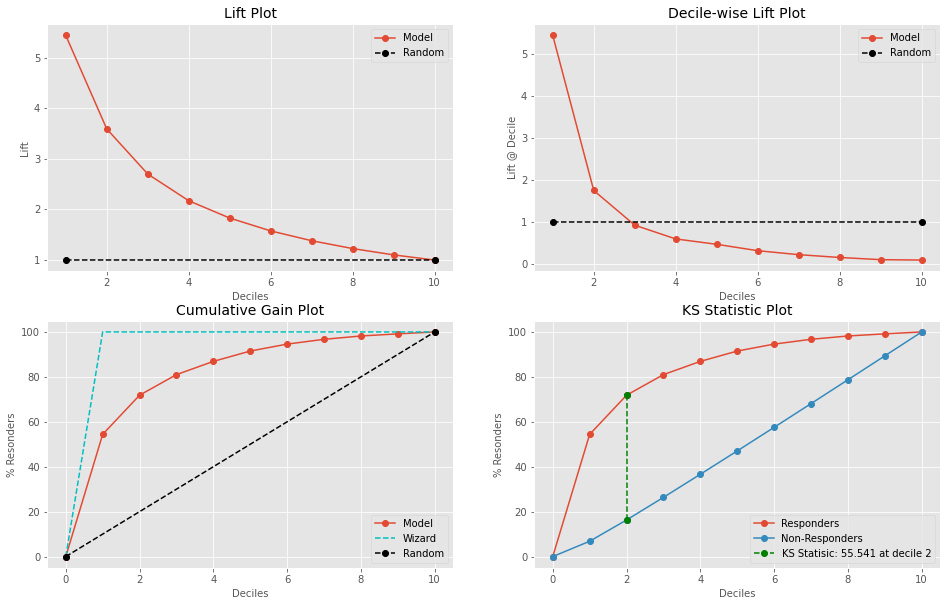

In [12]:
print("ROC",roc_auc_score(y_test_bin,X_test_bin['prediction']))
kds.metrics.report(y_test_bin,X_test_bin['prediction'],plot_style='ggplot')

In [13]:
clf_pickle = open('xgbmodel','wb')
pickle.dump(clf,clf_pickle)
clf_pickle.close()

In [14]:
df_lblencode = pd.read_csv('lblencode_map.csv')
lblenc_dict = df_lblencode.to_dict('dict')
age_bin = X_test_bin['AGE_BIN']
age_bin.map(lblenc_dict).fillna(-1).astype(int)

3724    -1
73069   -1
36497   -1
21405   -1
33642   -1
        ..
77902   -1
34278   -1
3850    -1
70177   -1
53      -1
Name: AGE_BIN, Length: 31500, dtype: int32

In [15]:
X_test_bin['AGE_BIN']

3724     5
73069    4
36497    4
21405    1
33642    6
        ..
77902    1
34278    4
3850     1
70177    3
53       5
Name: AGE_BIN, Length: 31500, dtype: int32